<a href="https://colab.research.google.com/github/Vidi005/Klasifikasi-3-Jenis-Beras-Tumpukan/blob/master/Klasifikasi%203%20Jenis%20Beras%20Tumpukan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikasi Jenis Beras

# **Mengambil Dataset dari Github**

In [0]:
!apt-get install subversion > /dev/null

!svn export https://github.com/Vidi005/Klasifikasi-3-Jenis-Beras-Tumpukan/trunk/data > /dev/null
!svn export https://github.com/Vidi005/Klasifikasi-3-Jenis-Beras-Tumpukan/trunk/utils > /dev/null
#!svn export https://github.com/Vidi005/Klasifikasi-3-Jenis-Beras-Tumpukan/trunk/Klasifikasi Beras Tumpukan.ipynb > /dev/null

## Persiapan

Program ini dibuat untuk membedakan 3 jenis beras yaitu :

1.   Jenis Beras IR 64
2.   Jenis Beras Cilamaya
3.   Jenis Beras Ketan

Pada program ini menggunakan metode Convolutional Neural Network (CNN) untuk melakukan klasifikasinya.

## Memasukan Fungsi Library

In [0]:
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

Using TensorFlow backend.


## Mengimpor Dataset

In [0]:
#Perintah di bawah ini untuk melihat list bagian dari file yang sudah diunduh dari Github
!ls data/image
!ls data/image/train
!ls data/image/train/Cilamaya
!ls data/image/train/IR64
!ls data/image/train/Ketan

test  test.txt	train  train.txt
Cilamaya  IR64	Ketan
C10.jpg  C13.jpg  C16.jpg  C19.jpg  C21.jpg  C24.jpg  C3.jpg  C6.jpg  C9.jpg
C11.jpg  C14.jpg  C17.jpg  C1.jpg   C22.jpg  C25.jpg  C4.jpg  C7.jpg
C12.jpg  C15.jpg  C18.jpg  C20.jpg  C23.jpg  C2.jpg   C5.jpg  C8.jpg
I10.jpg  I13.jpg  I16.jpg  I19.jpg  I21.jpg  I24.jpg  I3.jpg  I6.jpg  I9.jpg
I11.jpg  I14.jpg  I17.jpg  I1.jpg   I22.jpg  I25.jpg  I4.jpg  I7.jpg
I12.jpg  I15.jpg  I18.jpg  I20.jpg  I23.jpg  I2.jpg   I5.jpg  I8.jpg
K10.jpg  K13.jpg  K16.jpg  K19.jpg  K21.jpg  K24.jpg  K3.jpg  K6.jpg  K9.jpg
K11.jpg  K14.jpg  K17.jpg  K1.jpg   K22.jpg  K25.jpg  K4.jpg  K7.jpg
K12.jpg  K15.jpg  K18.jpg  K20.jpg  K23.jpg  K2.jpg   K5.jpg  K8.jpg


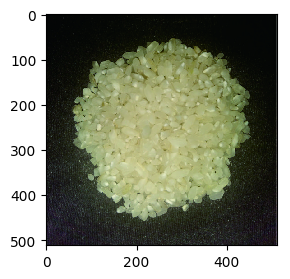

In [0]:
#Perintah untuk memvisualisasikan satu gambar dari data train
image = imread("data/image/train/Cilamaya/C17.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [0]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset training
X_train = []
y_train = []
labels = ['Cilamaya', 'IR64', 'Ketan']

for i,label in enumerate(labels):
    folder = os.path.join("data/image/train",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(300,300))
        X_train.append(image)
        category = os.path.split(folder)[-1]
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

#Memuat dataset test
X_test = []
y_test = []
labels = ['Cilamaya', 'IR64', 'Ketan']

for i,label in enumerate(labels):
    folder = os.path.join("data/image/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(300,300))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Bentuk array dari dataset train (pelatihan) adalah:", X_train.shape,y_train.shape)
print("Bentuk array dari dataset test (tes) adalah:", X_test.shape,y_test.shape)

train dataset shape is: (75, 300, 300, 3) (75,)
test dataset shape is: (15, 300, 300, 3) (15,)


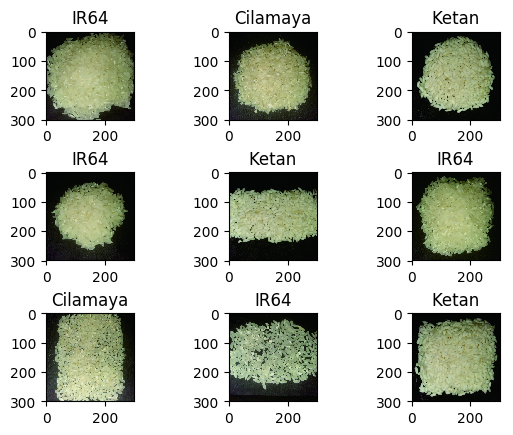

In [0]:
plt.subplots_adjust(wspace=0.4, hspace=0.6)

#Menampilkan beberapa gambar dari dataset pelatihan secara acak
index = np.random.randint(0,X_train.shape[0],size=9)

for i, idx  in enumerate(index):
    plt.subplot(3,3,i+1)
    
    if y_train[idx] == 0:
        label = "Cilamaya"
    elif y_train[idx] == 1:
        label = "IR64"
    else:
        label = "Ketan"
    plt.title(label)
    plt.imshow(X_train[idx])

# Mengelompokkan Klasifikasi Tiga Jenis Beras dengan Deep learning (Convolutional Neural Network)

Sesudah mengimpor dataset, kita akan menggunakan CNN, salah satu arsitektur Deep Learning yang dapat menghandle gambar. Dengan menggunakan Deep CNN, kita dibebaskan dari pendefinisian fitur yang cocok dan hanya memberikan gambar-gambar ke jaringan. CNN akan menentukan fitur yang paling cocok untuk pengklasifikasian.

In [0]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

## Mempersiapkan Data Masukkan

In [0]:
y_train2 = to_categorical(y_train)
X_train3, X_valid3, y_train3, y_valid3 = train_test_split(X_train, y_train2, test_size=0.2, random_state=1)
y_test2 = to_categorical(y_test)
X_test3, X_valid3, y_test3, y_valid3 = train_test_split(X_test, y_test2, test_size=0.4, random_state=1)

## Pembuatan Model

In [0]:
model = Sequential([
    layers.Conv2D(16, (3,3), input_shape=(300,300,3),name="conv1"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool1"),
    layers.Dropout(0.25),
    layers.Conv2D(32, (3,3),name="conv2"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool2"),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64,name="fc1"),
    layers.Activation("relu"),
    layers.Dense(3,name="fc2"),
    layers.Activation("softmax")
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 298, 298, 16)      448       
_________________________________________________________________
activation_5 (Activation)    (None, 298, 298, 16)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 149, 149, 16)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 149, 149, 16)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 147, 147, 32)      4640      
_________________________________________________________________
activation_6 (Activation)    (None, 147, 147, 32)      0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 73, 73, 32)       

## Pelatihan

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan model bobot yang terbaik selama training
ckpt = ModelCheckpoint("Klasifikasi Beras Tumpukan.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit(x = X_train3, y = y_train3, batch_size=300, epochs= 100,validation_data=(X_valid3,y_valid3),callbacks = [ckpt])

Train on 60 samples, validate on 6 samples
Epoch 1/100
60/60 [==============================] - 1s 14ms/step - loss: 1.1388 - acc: 0.3000 - val_loss: 3.8304 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 3.83041, saving model to Klasifikasi Beras Tumpukan.h5
Epoch 2/100
60/60 [==============================] - 0s 5ms/step - loss: 3.7971 - acc: 0.3667 - val_loss: 10.5186 - val_acc: 0.1667

Epoch 00002: val_loss did not improve from 3.83041
Epoch 3/100
60/60 [==============================] - 0s 4ms/step - loss: 7.7523 - acc: 0.3333 - val_loss: 7.6860 - val_acc: 0.1667

Epoch 00003: val_loss did not improve from 3.83041
Epoch 4/100
60/60 [==============================] - 0s 4ms/step - loss: 5.2253 - acc: 0.3333 - val_loss: 5.7424 - val_acc: 0.3333

Epoch 00004: val_loss did not improve from 3.83041
Epoch 5/100
60/60 [==============================] - 0s 4ms/step - loss: 4.3425 - acc: 0.3000 - val_loss: 3.8330 - val_acc: 0.3333

Epoch 00005: val_loss did not improve from 3

## Menggambarkan Hasil Pelatihan

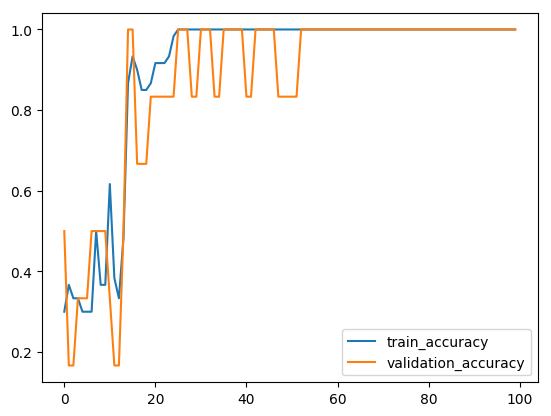

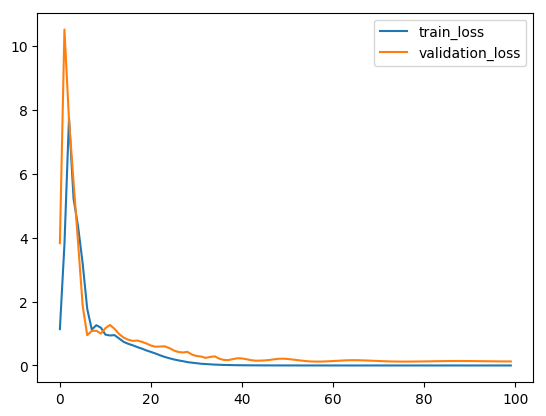

In [0]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kegagalan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kegagalan")
plt.legend()
plt.show()

## Gunakan Model

In [0]:
print(X_train3.shape)

(60, 300, 300, 3)


In [0]:
n = 59
input_image = X_train3[n][np.newaxis,...]
print("Labelnya adalah: ", y_train3[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

label is:  [0. 1. 0.]
prediction is [9.0186528e-05 9.9988425e-01 2.5517002e-05]


See that we just input image and get the results, while step 1 and step 2 required to construct feature(s) by our self.
This seed classification task was quite easy, but the complex the image gets, the harder to construct the most suitable feature gets.
That is when CNN shows its power.
See also the Yeast GFP protein localization tutorial for more complex image classification task.

## Evaluasi

In [0]:
#Memuat file bobot model dengan paling sedikit data validasi yang hilang/error
model.load_weights("Klasifikasi Beras Tumpukan.h5")

In [0]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(x= X_train3, y = y_train3))
#Evaluasi validasi data
print(model.evaluate(x= X_valid3, y = y_valid3))
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3)) 

['loss', 'acc']
60/60 [==============================] - 0s 2ms/step
[0.0002819319604896009, 1.0]
6/6 [==============================] - 0s 3ms/step
[0.12172726541757584, 1.0]
9/9 [==============================] - 0s 2ms/step
[0.3870745301246643, 0.7777777910232544]


In [0]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]
[0 0 0 0 0 0 1 1 1 1 2 2 2 1 2]


## Prediksi Gambar Individual

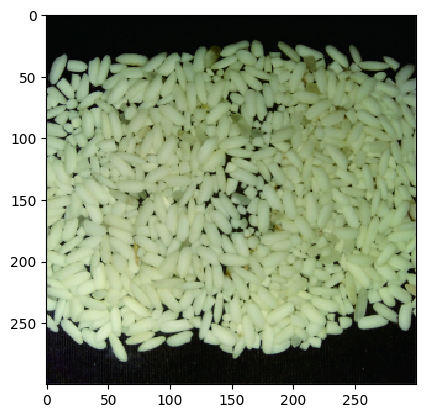

true_label is: 2 : Ketan
predicted_value is: [1.2480315e-04 1.5270290e-02 9.8460490e-01]
predicted_label is: 2 : Ketan
correct prediction


In [0]:
n = 14 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

# Membuat File *.h5 untuk Tensorflow Lite

In [0]:
import os
os.makedirs('./model', exist_ok=True)
model.save('./model/Klasifikasi Beras Tumpukan.hdf5')

In [0]:
from keras import backend as K
# This line must be executed before loading Keras model.
K.set_learning_phase(0)

In [0]:
from keras.models import load_model
model = load_model('./model/Klasifikasi Beras Tumpukan.hdf5')
print(model.outputs)
# [<tf.Tensor 'dense_2/Softmax:0' shape=(?, 10) dtype=float32>]
print(model.inputs)
# [<tf.Tensor 'conv2d_1_input:0' shape=(?, 28, 28, 1) dtype=float32>]

[<tf.Tensor 'activation_8_1/Softmax:0' shape=(?, 3) dtype=float32>]
[<tf.Tensor 'conv1_input_3:0' shape=(?, 300, 300, 3) dtype=float32>]


# Menyimpan File *.pb

In [0]:
from keras import backend as K
import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

INFO:tensorflow:Froze 148 variables.
INFO:tensorflow:Converted 148 variables to const ops.


In [0]:
# Save to ./model/tf_model.pb
tf.train.write_graph(frozen_graph, "model", "tf_Klasifikasi_Beras_Tumpukan.pb", as_text=False)

'model/tf_Klasifikasi_Beras_Tumpukan.pb'

# Memuat File .pb dan Memprediksikannya

In [0]:
import tensorflow as tf
from tensorflow.python.platform import gfile

f = gfile.FastGFile("./model/tf_Klasifikasi_Beras_Tumpukan.pb", 'rb')
graph_def = tf.GraphDef()
# Parses a serialized binary message into the current message.
graph_def.ParseFromString(f.read())
f.close()

sess = tf.Session()
sess.graph.as_default()
# Import a serialized TensorFlow `GraphDef` protocol buffer
# and place into the current default `Graph`.
tf.import_graph_def(graph_def)

In [0]:
#softmax_tensor = sess.graph.get_tensor_by_name('import/dense_2/Softmax:0')
#predictions = sess.run(softmax_tensor, {'import/conv2d_1_input:0': x_test[:20]})

In [0]:
#predicts_1, predicts_2 = sess.run([output_tensor1, output_tensor2], {
#    'import/input0:0': x_1[:20], 'import/input1:0': x_2[:20]})

In [0]:
#from show_graph import show_graph
#import tensorflow as tf
# Show current session graph with TensorBoard in Jupyter Notebook.
#show_graph(tf.get_default_graph().as_graph_def())

In [0]:
X_train3[1]

array([[[0.73074448, 0.73414874, 0.74495924],
        [0.08525966, 0.08927603, 0.10429144],
        [0.07838721, 0.08421365, 0.09156424],
        ...,
        [0.07848398, 0.08816426, 0.08152804],
        [0.08288316, 0.08708602, 0.08873372],
        [0.6356257 , 0.64298647, 0.63973879]],

       [[0.71759542, 0.72198493, 0.72728473],
        [0.01648099, 0.02726667, 0.02730058],
        [0.02539422, 0.02912109, 0.01960694],
        ...,
        [0.01544945, 0.02062897, 0.01578938],
        [0.01964509, 0.02385926, 0.01940289],
        [0.63948902, 0.64115999, 0.63376494]],

       [[0.71335413, 0.71773372, 0.70394131],
        [0.02944888, 0.03685521, 0.0336452 ],
        [0.04361698, 0.04394117, 0.04132955],
        ...,
        [0.01953982, 0.02807569, 0.02409358],
        [0.01757064, 0.02473845, 0.01996666],
        [0.61310074, 0.62635167, 0.62672656]],

       ...,

       [[0.80420848, 0.79534623, 0.81163504],
        [0.24548518, 0.19673196, 0.25808352],
        [0.27805179, 0